In [22]:
from sympy.physics.optics import RayTransferMatrix, ThinLens, BeamParameter
from sympy import symbols, init_printing, pi, sqrt, pprint, solveset, S
from scipy.constants import c
import matplotlib.pyplot as plt
import numpy as np
init_printing()
from ipywidgets.widgets import (IntSlider, FloatLogSlider, FloatSlider, interactive_output, 
                                FloatRangeSlider, BoundedFloatText, Checkbox, HBox, VBox, IntRangeSlider, 
                                BoundedIntText, Text, Button, Label)
from IPython.display import display
import datetime, os


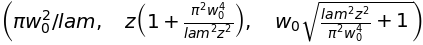

In [23]:
w, lam, w0, z = symbols("w, lam, w0, z", positive=True)

# defining the confocal length, R(z) and w(z) in sympy
z_r = pi * w0 ** 2 / lam
R = z * (1 + (z_r / z) ** 2)
w = w0 * sqrt(1 + (z / z_r) ** 2)

# Defining the z-propagation range
z_ = np.linspace(0, 20, 10)

# Defining functions
def ghz_cm(x):
    return c * 1e2 / x * 1e-9


z_r, R, w

In [33]:
class gaussian_simulation:
    def __init__(self):

        W = BoundedFloatText(value=0.37, min=0.1, max=1, step=0.01, description="w0:")
        L = IntRangeSlider(
            value=[629, 1000], min=100, max=1200, step=1, description="GHz"
        )

        width = BoundedIntText(value=12, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=7, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=100, min=70, max=250, step=1, description="Dpi")

        entry1 = BoundedFloatText(
            value=-7.4, min=-10, max=10, step=0.1, description="Entry1"
        )
        entry2 = BoundedFloatText(
            value=3, min=0, max=10, step=0.1, description="Entry2"
        )

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Info: ")

        row1 = HBox([W, L])
        row2 = HBox([width, height, dpi])
        row3 = HBox([entry1, entry2])

        out = interactive_output(
            self.simulate,
            {
                "w0_": W,
                "wn": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "entry1": entry1,
                "entry2": entry2,
            },
        )

        display(
            VBox([row1, row2, row3, out, self.save_name, save_button, self.print_save])
        )

    def save_plot(self, event):

        self.fig0.savefig(f"./{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def beam_plot(self, ax, w0_, wn):

        self.gaussian_beam(w0_, wn)

        for c, beam in enumerate(self.beams):
            color = f"C{c}"
            ax.plot(
                z_,
                beam,
                f"--{color}",
                label=f"{self.wn[c]:.2f} GHz ({ghz_cm(self.wn[c]):.2f} cm)",
            )
            ax.plot(-z_, -beam, f"--{color}")
            ax.plot(-z_, beam, f"--{color}")
            ax.plot(z_, -beam, f"--{color}")

    def simulate(self, w0_, wn, width, height, dpi, entry1, entry2):

        self.fig0, ax0 = plt.subplots(figsize=(width, height), dpi=dpi)
        self.beam_plot(ax0, w0_, wn)

        ax0.hlines(0, xmin=-z_.max(), xmax=z_.max())

        ## Annotation begins

        # Distance b/w two entry points
        ax0.hlines(-0.2, xmin=entry1, xmax=entry2)
        plt.annotate(
            s=f"d={(entry2-entry1):.2f}",
            xy=(0, 0),
            xytext=(0, -0.3),
            ha="center",
            va="center",
        )

        # Annotate beam waist
        ax0.vlines(x=0, ymin=0, ymax=w0_)
        plt.annotate(
            s=f"w0={w0_} cm",
            xy=(0, w0_),
            xytext=(0, 0.5),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry1
        ax0.vlines(x=entry1, ymin=-1, ymax=1)

        plt.annotate(
            s="Entry I: height=2cm",
            xy=(entry1, 1),
            xytext=(entry1 - 5, 1),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry2
        ax0.vlines(x=entry2, ymin=-0.43, ymax=0.43)

        plt.annotate(
            s="Entry II: height=0.86cm",
            xy=(entry2, 0.43),
            xytext=(entry2 + 5, 0.7),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate z-position

        plt.annotate(s="z=0", xy=(0, 0), xytext=(0, -0.05), ha="center", va="center")

        plt.annotate(
            s=f"z={entry2}",
            xy=(entry2, 0),
            xytext=(entry2 + 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        plt.annotate(
            s=f"z={entry1}",
            xy=(entry1, 0),
            xytext=(entry1 - 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        ## Annotation ends

        ax0.set_xlabel("Z-position (cm)")
        ax0.set_ylabel("w-Gaussian Beam radius (cm)")
        ax0.set_title(f"Gaussian Beam simulation: {wn[0]}-{wn[-1]} GHz")
        ax0.legend()
        plt.show()
        # plt.close()

        self.save_name.value = f"{w0_}cm-{wn[0]}-{wn[-1]}GHz_simulation"

    def gaussian_beam(self, w0_, wn):

        global w, z_

        self.wn = np.linspace(*wn, 10)

        beam = []
        beams = []

        for l in self.wn:

            temp = []
            beam = []

            for i in z_:
                temp = float(w.subs({w0: w0_, lam: ghz_cm(l), z: i}).evalf())
                beam.append(temp)
            beams.append(beam)

        self.beams = np.array(beams)

In [39]:
#%matplotlib widget
%matplotlib inline
start = gaussian_simulation()

In [37]:
plt.close('all')